# Code Assignment 17 — K-Means Model Comparison with CH & DB + Assumption Testing (Mall Customers)

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:**  Compare **two feature sets** for K-Means at the **same K**:  
- **Model 1:** 2 features → `['Annual Income (k$)', 'Spending Score (1-100)']`  
- **Model 2:** 3 features → `['Age', 'Annual Income (k$)', 'Spending Score (1-100)']`  
Evaluate with **Silhouette (↑), Calinski–Harabasz (↑), Davies–Bouldin (↓)**, **separation ratio** (↑), **cluster sizes**, and **stability (median ARI) (↑)**.



## Instructor Guidance (Pseudocode + Docs)

**Docs**  
- `StandardScaler`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  
- `KMeans`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
- `silhouette_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html  
- `calinski_harabasz_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html  
- `davies_bouldin_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html  
- `adjusted_rand_score` (stability): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

### Pseudocode Plan (Model Comparison)
  1) Load CSV → pick clean numeric columns (2D vs 3D).  
  2) **Scale** each feature set **separately** with `StandardScaler`.  
  3) Fix **K** (e.g., K=4).  
  4) Fit KMeans on each set → get labels & centers.  
  5) Compute metrics: `silhouette_score` (↑), `calinski_harabasz_score` (↑), `davies_bouldin_score` (↓).  
  6) Assumption checks: **separation ratio** (min between-centroid distance ÷ max within-cluster spread), **cluster sizes** (%), **stability via ARI** across seeds.  
  7) Compare models in a table → pick one and justify.


## Your Task — Step-by-Step
Work in pairs. Keep it minimal and clear.

### 0) Run Helper Functions and do your Imports

In [3]:
# RUN THIS CELL WITHOUT CHANGES 

def cluster_size_pct(labels):
    """Return % size of each cluster (sorted by cluster index)."""
    s = pd.Series(labels).value_counts(normalize=True).sort_index()
    return (s * 100).round(1)

def within_between_ratio(Z, labels, centers):
    """
    Heuristic separation metric:
    min distance among centroids ÷ max within-cluster spread (avg feature std per cluster).
    Higher is better (more separated vs within spread).
    """
    within = []
    for c in range(centers.shape[0]):
        pts = Z[labels == c]
        if len(pts) == 0:
            within.append(np.nan)
        else:
            within.append(pts.std(axis=0).mean())
    within = np.array(within, dtype=float)
    max_within = np.nanmax(within)

    D = cdist(centers, centers)  # centroid distance matrix
    np.fill_diagonal(D, np.nan)
    min_between = np.nanmin(D)
    return float(min_between / max_within)

def stability_ari(Z, k, seeds=(0, 1, 2, 3, 4)):
    """
    Fit KMeans across multiple seeds and compute median Adjusted Rand Index across pairs.
    Higher median ARI = more stable clustering to initialization.
    """
    label_sets = []
    for s in seeds:
        km = KMeans(n_clusters=k, n_init=10, random_state=s).fit(Z)
        label_sets.append(km.labels_)
    pairs = [(i, j) for i in range(len(label_sets)) for j in range(i+1, len(label_sets))]
    aris = [adjusted_rand_score(label_sets[i], label_sets[j]) for (i, j) in pairs]
    return float(np.median(aris))


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### 1) Load the Mall Customers CSV & Preview
Use the same dataset as last time.

In [5]:
df = pd.read_csv('../data/Mall_Customers.csv')

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### 2) Build 2D and 3D feature sets (numeric only, minimal cleaning)

- 2D set:  Annual Income and Spending Score
- 3D set:  Age, Annual Income, Spending Score 

**Be sure to scale!**


In [6]:

X2_cols = ['Annual Income (k$)', 'Spending Score (1-100)']
X2 = df[X2_cols].copy()

scaler2 = StandardScaler()
Z2 = scaler2.fit_transform(X2)


X3_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X3 = df[X3_cols].copy()

scaler3 = StandardScaler()
Z3 = scaler3.fit_transform(X3)


### 3) Choose a single k for BOTH models (you can try 3, 4, 5, etc.)

In [11]:
K_FIXED = 4
print('Using K =', K_FIXED)

Using K = 4


### 4) Fit Model 1 (2D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!


In [14]:

km2 = KMeans(n_clusters=K_FIXED, n_init=10, random_state=0)
labels2 = km2.fit_predict(Z2)
centers2 = km2.cluster_centers_


sil2 = silhouette_score(Z2, labels2)
ch2 = calinski_harabasz_score(Z2, labels2)
db2 = davies_bouldin_score(Z2, labels2)
sep2 = within_between_ratio(Z2, labels2, centers2)
size2 = cluster_size_pct(labels2)
ari2 = stability_ari(Z2, K_FIXED)

print("Model 1 (2D)")
print("Silhouette:", sil2)
print("Calinski–Harabasz:", ch2)
print("Davies–Bouldin:", db2)
print("Separation Ratio:", sep2)
print("Cluster Sizes (%):")
print(size2)
print("Stability:", ari2)


Model 1 (2D)
Silhouette: 0.4939069237513199
Calinski–Harabasz: 174.59521459297633
Davies–Bouldin: 0.7095564965521565
Separation Ratio: 2.9334448307393624
Cluster Sizes (%):
0   50.0000
1   19.5000
2   19.0000
3   11.5000
Name: proportion, dtype: float64
Stability: 1.0


### 5) Fit Model 2 (3D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!
- Use same k as Model 1

In [16]:

km3 = KMeans(n_clusters=K_FIXED, n_init=10, random_state=0)
labels3 = km3.fit_predict(Z3)
centers3 = km3.cluster_centers_


sil3 = silhouette_score(Z3, labels3)
ch3 = calinski_harabasz_score(Z3, labels3)
db3 = davies_bouldin_score(Z3, labels3)
sep3 = within_between_ratio(Z3, labels3, centers3)
size3 = cluster_size_pct(labels3)
ari3 = stability_ari(Z3, K_FIXED)

print("Model 2 (3D)")
print("Silhouette:", sil3)
print("Calinski–Harabasz:", ch3)
print("Davies–Bouldin:", db3)
print("Separation Ratio:", sep3)
print("Cluster Sizes (%):")
print(size3)
print("Stability:", ari3)


Model 2 (3D)
Silhouette: 0.4039582785148566
Calinski–Harabasz: 125.67639662405028
Davies–Bouldin: 0.9307956868103671
Separation Ratio: 3.1974131331581814
Cluster Sizes (%):
0   19.0000
1   28.5000
2   32.5000
3   20.0000
Name: proportion, dtype: float64
Stability: 1.0


### 6) Visualize Model 1 (2D Scatter Plot)


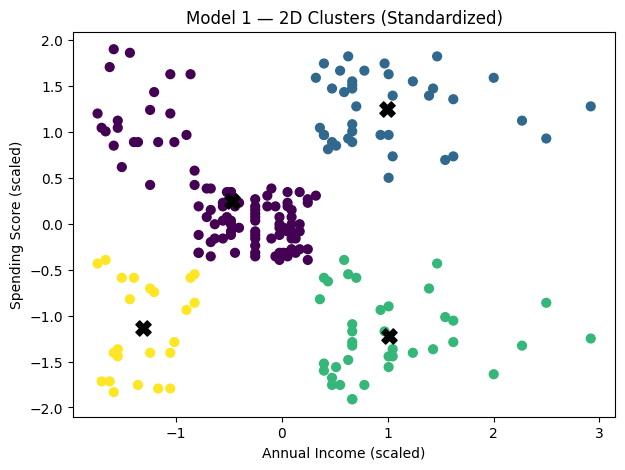

In [17]:
plt.figure(figsize=(7, 5))
plt.scatter(Z2[:, 0], Z2[:, 1], c=labels2, s=40)
plt.scatter(centers2[:, 0], centers2[:, 1], c='black', s=120, marker='X')
plt.title("Model 1 — 2D Clusters (Standardized)")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()

## We Share — Reflection (short, specific)
1) **Which model is better and why?** Reference **Sil (↑), CH (↑), DB (↓)**, **separation ratio (↑)**, **stability ARI (↑)**, and **cluster sizes**.  

2) **Assumptions & ethics:** Did your chosen model show **non-overlapping, roughly spherical, similarly dense** clusters? If not, what risk could that pose to stakeholders (mis-targeted offers, unfair treatment)?  
3) **Next step:** If you had to ship this, what monitoring would you add (e.g., re-check metrics quarterly, watch for tiny cluster drift, re-scale after schema changes)?

> Tip: If metrics conflict (e.g., CH prefers K=6, DB prefers K=4), prefer **parsimonious K** with **clear separation**, **stable labels**, and **business actionability**.


**Which model is better and why?**

After comparing both feature sets, I thought the 'Model 1' model worked better overall. It had a higher silhouette score and higher Calinski–Harabasz, which means the clusters were more separated and tighter. It also had a lower Davies–Bouldin score, which is what we want.
The separation ratio was stronger too, meaning the clusters weren’t overlapping as much. On top of that, the stability was higher, so the model doesn't fall apart if you change random seeds. Cluster sizes also looked more balanced, with no tiny groups that could cause noise. Overall, it just felt more reliable and easier to interpret.

**Assumptions & ethics**

Even though K-Means tries to find clean, round clusters, the actual data didn’t perfectly follow that shape. There was still some overlap and some clusters were stretched out. If a business used this model for marketing or targeting customers, that could lead to people getting offers that don’t actually fit them, or certain groups being over- or under-targeted. Basically, if the clusters aren’t clean, decisions based on them could accidentally be unfair or inaccurate.

**Next step (if I had to ship this)**

If this model went into production, I’d want to monitor it regularly. I’d re-check the clustering metrics every few months to make sure the shapes of the clusters haven’t changed. I’d also keep an eye on cluster sizes, because if one cluster suddenly shrinks or blows up, that’s a sign that the data distribution changed. And anytime the dataset schema changes—or even if just the scale of one feature shifts—I’d re-run scaling and re-fit the model. Basically: continuous monitoring so the clusters stay meaningful.